In [3]:
test= [1,2,3]
test.append(4)
test

[1, 2, 3, 4]

In [5]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
tf.enable_eager_execution()
tf.__version__
import IPython.display as display
import pathlib
import random
import os
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [3]:

data_root_orig = tf.keras.utils.get_file('flower_photos',
                                         'https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
                                         untar=True)
data_root = pathlib.Path(data_root_orig)
print(data_root)

C:\Users\Rbudn\.keras\datasets\flower_photos


In [4]:
for item in data_root.iterdir():
    print(item)

C:\Users\Rbudn\.keras\datasets\flower_photos\daisy
C:\Users\Rbudn\.keras\datasets\flower_photos\dandelion
C:\Users\Rbudn\.keras\datasets\flower_photos\LICENSE.txt
C:\Users\Rbudn\.keras\datasets\flower_photos\roses
C:\Users\Rbudn\.keras\datasets\flower_photos\sunflowers
C:\Users\Rbudn\.keras\datasets\flower_photos\tulips


In [5]:

all_image_paths = list(data_root.glob('*/*'))
all_image_paths = [str(path) for path in all_image_paths]
random.shuffle(all_image_paths)

image_count = len(all_image_paths)
image_count

3670

In [6]:
all_image_paths[:10]


['C:\\Users\\Rbudn\\.keras\\datasets\\flower_photos\\sunflowers\\164670455_29d8e02bbd_n.jpg',
 'C:\\Users\\Rbudn\\.keras\\datasets\\flower_photos\\dandelion\\18889216716_cd67aec890_n.jpg',
 'C:\\Users\\Rbudn\\.keras\\datasets\\flower_photos\\roses\\2053476785_c162a3e358.jpg',
 'C:\\Users\\Rbudn\\.keras\\datasets\\flower_photos\\sunflowers\\5955475577_3d923874d9_n.jpg',
 'C:\\Users\\Rbudn\\.keras\\datasets\\flower_photos\\tulips\\2440874162_27a7030402_n.jpg',
 'C:\\Users\\Rbudn\\.keras\\datasets\\flower_photos\\sunflowers\\3514340206_efb8198a80_n.jpg',
 'C:\\Users\\Rbudn\\.keras\\datasets\\flower_photos\\sunflowers\\4895718876_0246882882_n.jpg',
 'C:\\Users\\Rbudn\\.keras\\datasets\\flower_photos\\daisy\\9310226774_d1b8f5d9c9.jpg',
 'C:\\Users\\Rbudn\\.keras\\datasets\\flower_photos\\dandelion\\6972675188_37f1f1d6f6.jpg',
 'C:\\Users\\Rbudn\\.keras\\datasets\\flower_photos\\sunflowers\\27466794_57e4fe5656.jpg']

In [15]:

attributions = (data_root/"LICENSE.txt").open(encoding='utf-8').readlines()[4:]
attributions = [line.split(' CC-BY') for line in attributions]
attributions = dict(attributions)

In [16]:
def caption_image(image_path):
    image_rel = pathlib.Path(image_path).relative_to(data_root)
    return "Image (CC BY 2.0) " + ' - '.join(attributions[str(image_rel)].split(' - ')[:-1])

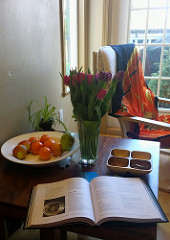

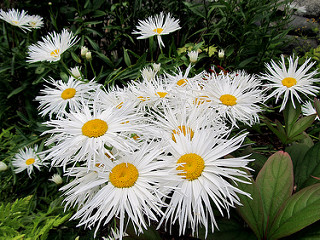

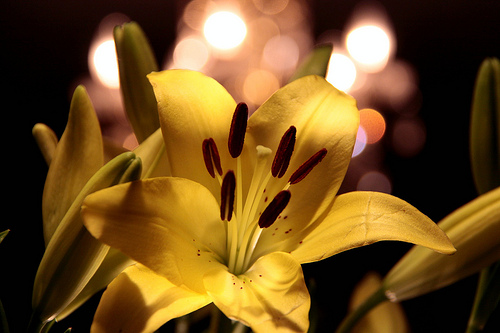

In [18]:
for n in range(3):
    image_path = random.choice(all_image_paths)
    display.display(display.Image(image_path))
#     print(caption_image(image_path))
    print()

In [19]:
label_names = sorted(item.name for item in data_root.glob('*/') if item.is_dir())
label_names

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

In [20]:
label_to_index = dict((name, index) for index,name in enumerate(label_names))
label_to_index

{'daisy': 0, 'dandelion': 1, 'roses': 2, 'sunflowers': 3, 'tulips': 4}

In [21]:
all_image_labels = [label_to_index[pathlib.Path(path).parent.name]
                    for path in all_image_paths]

print("First 10 labels indices: ", all_image_labels[:10])

First 10 labels indices:  [3, 1, 2, 3, 4, 3, 3, 0, 1, 3]


In [22]:
img_path = all_image_paths[0]
img_path

'C:\\Users\\Rbudn\\.keras\\datasets\\flower_photos\\sunflowers\\164670455_29d8e02bbd_n.jpg'

In [23]:
img_raw = tf.io.read_file(img_path)
print(repr(img_raw)[:100]+"...")

<tf.Tensor: id=1, shape=(), dtype=string, numpy=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x...


In [24]:
img_tensor = tf.image.decode_image(img_raw)

print(img_tensor.shape)
print(img_tensor.dtype)

(228, 320, 3)
<dtype: 'uint8'>


In [25]:
img_final = tf.image.resize(img_tensor, [192, 192])
img_final = img_final/255.0
print(img_final.shape)
print(img_final.numpy().min())
print(img_final.numpy().max())

(192, 192, 3)
0.0
1.0


In [75]:
def preprocess_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [224, 224])
    image /= 255.0  # normalize to [0,1] range

    return image

def load_and_preprocess_image(path):
    image = tf.read_file(path)
    return preprocess_image(image)

Text(0.5, 1.0, 'Sunflowers')

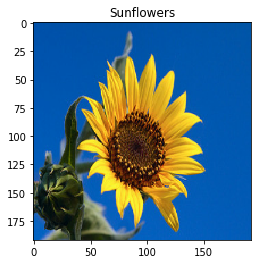

In [29]:
import matplotlib.pyplot as plt

img_path = all_image_paths[0]
label = all_image_labels[0]

plt.imshow(load_and_preprocess_image(img_path))
plt.grid(False)
# plt.xlabel(caption_image(img_path).encode('utf-8'))
plt.title(label_names[label].title())
# print()

In [30]:
path_ds = tf.data.Dataset.from_tensor_slices(all_image_paths)

In [32]:
print('shape: ', repr(path_ds.output_shapes))
print('type: ', path_ds.output_types)
print()
print(path_ds)

shape:  TensorShape([])
type:  <dtype: 'string'>

<DatasetV1Adapter shapes: (), types: tf.string>


In [33]:
image_ds = path_ds.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)

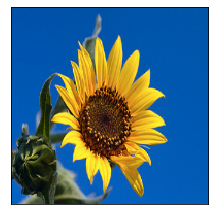

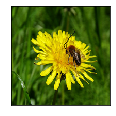

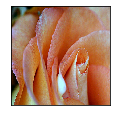

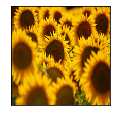

In [35]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,8))
for n,image in enumerate(image_ds.take(4)):
    plt.subplot(2,2,n+1)
    plt.imshow(image)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
#     plt.xlabel(caption_image(all_image_paths[n]))
    plt.show()

In [36]:
label_ds = tf.data.Dataset.from_tensor_slices(tf.cast(all_image_labels, tf.int64))

In [37]:
for label in label_ds.take(10):
    print(label_names[label.numpy()])

sunflowers
dandelion
roses
sunflowers
tulips
sunflowers
sunflowers
daisy
dandelion
sunflowers


In [38]:
image_label_ds = tf.data.Dataset.zip((image_ds, label_ds))

In [39]:
print(image_label_ds)

<DatasetV1Adapter shapes: ((192, 192, 3), ()), types: (tf.float32, tf.int64)>


In [40]:
ds = tf.data.Dataset.from_tensor_slices((all_image_paths, all_image_labels))

# The tuples are unpacked into the positional arguments of the mapped function
def load_and_preprocess_from_path_label(path, label):
    return load_and_preprocess_image(path), label

image_label_ds = ds.map(load_and_preprocess_from_path_label)
image_label_ds

<DatasetV1Adapter shapes: ((192, 192, 3), ()), types: (tf.float32, tf.int32)>

In [41]:
AUTOTUNE

-1

In [44]:
import pandas as pd
filename="train_controls_root.csv"
df = pd.read_csv(filename,  dtype={'sirna': object})

In [60]:
df

,Unnamed: 0,id_code,experiment,plate,well,sirna,well_type,img_path_root,cell_type
0,0,HEPG2-01_1_B02,HEPG2-01,1,B02,30,negative_control,train/HEPG2-01/Plate1/B02_s1,HEPG2
1,1,HEPG2-01_1_B02,HEPG2-01,1,B02,30,negative_control,train/HEPG2-01/Plate1/B02_s2,HEPG2
2,2,HEPG2-01_1_C03,HEPG2-01,1,C03,1,positive_control,train/HEPG2-01/Plate1/C03_s1,HEPG2
3,3,HEPG2-01_1_C03,HEPG2-01,1,C03,1,positive_control,train/HEPG2-01/Plate1/C03_s2,HEPG2
4,4,HEPG2-01_1_C07,HEPG2-01,1,C07,13,positive_control,train/HEPG2-01/Plate1/C07_s1,HEPG2
5,5,HEPG2-01_1_C07,HEPG2-01,1,C07,13,positive_control,train/HEPG2-01/Plate1/C07_s2,HEPG2
6,6,HEPG2-01_1_C11,HEPG2-01,1,C11,18,positive_control,train/HEPG2-01/Plate1/C11_s1,HEPG2
7,7,HEPG2-01_1_C11,HEPG2-01,1,C11,18,positive_control,train/HEPG2-01/Plate1/C11_s2,HEPG2
8,8,HEPG2-01_1_C15,HEPG2-01,1,C15,10,positive_control,train/HEPG2-01/Plate1/C15_s1,HEPG2
9,9,HEPG2-01_1_C15,HEPG2-01,1,C15,10,positive_control,train/HEPG2-01/Plate1/C15_s2,HEPG2


In [70]:
FILEPATH = "tf_test_1.tfrecord"
writer = tf.python_io.TFRecordWriter(FILEPATH)

In [52]:
import cv2


In [63]:
x = df["img_path_root"]
y = df["sirna"]
root = x[0]
root

'train/HEPG2-01/Plate1/B02_s1'

In [62]:
img_paths = [root+f"_w{i}.png" for i in range(1,7)]
img_paths

['train/HEPG2-01/Plate1/B02_s1_w1.png',
 'train/HEPG2-01/Plate1/B02_s1_w2.png',
 'train/HEPG2-01/Plate1/B02_s1_w3.png',
 'train/HEPG2-01/Plate1/B02_s1_w4.png',
 'train/HEPG2-01/Plate1/B02_s1_w5.png',
 'train/HEPG2-01/Plate1/B02_s1_w6.png']

In [69]:
imgs = [cv2.resize(cv2.imread(img), (224,224)) for img in img_paths]

In [71]:
img_ds = tf.data.Dataset.from_tensor_slices(img_paths).map(tf.read_file)
# writer.write()

In [72]:
img_ds

<DatasetV1Adapter shapes: (), types: tf.string>

In [74]:
# tfrec = tf.data.experimental.TFRecordWriter('images.tfrec')
# tfrec.write(img_ds)
# writer.write(img_ds)

In [116]:
import os
# path = 'I:\kaggle\random-42\train'
path = "I:\\kaggle\\by_exp_plate_site-42"
# name = '001.tfrecord'
name = "HEPG2-01_p1_s1.tfrecord"
filename = os.path.join(path, name)
image_ds = tf.data.TFRecordDataset(filename, compression_type=tf.python_io.TFRecordCompressionType.GZIP)

TypeError: Expected string, got 2 of type 'int' instead.

In [109]:
image_ds

<TFRecordDatasetV1 shapes: (), types: tf.string>

In [85]:
from tfrecord_lite import decode_example

In [114]:
TFRECORD_COMPRESSION = tf.python_io.TFRecordCompressionType.GZIP


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

